**Armando Nicolás Acuña Zambrano**

# Proyecto 2

El objetivo principal del proyecto es aplicar el desarrollo del Deep Learning para realizar la detección y clasificación de objetos en imágenes y videos. Usando YOLO (You Only Look Once), una conocida familia de algoritmos de detección de objetos por su velocidad y precisión. En particular, se basará el trabajo en la versión YOLOv8, disponible en, https://github.com/ultralytics/ultralytics.

Los modelos YOLO disponibles se entrenan comúnmente con el conjunto de datos COCO de Microsoft (https://cocodataset.org), que consta de más de 200.000 imágenes anotadas que contienen más de 1,5 millones de objetos pertenecientes a 80 clases de objetos diferentes. Para el proyecto se usarán estos modelos previamente entrenados de dos maneras diferentes:



* Inferencia sobre imágenes y vídeos de prueba: Familiarizarse con la estructura de YOLOv8 utilizando uno de los modelos preentrenados con el conjunto de datos COCO y analizando cualitativamente los resultados obtenidos.
* Transfer Learning en un conjunto de datos personalizado para detectar una nueva clase de objeto. Seleccionar uno o diferentes conjuntos de datos personalizados para entrenar un modelo YOLOv8, es posible utilizar herramientas como Roboflow (https://roboflow.com). Analizar cuantitativa y cualitativamente los resultados obtenidos en las pruebas.



**Objetivos**
* Búsqueda de información. Comprender cómo funciona YOLO y cómo utilizar su estructura.
* Ejecutar inferencias en imágenes y videos de prueba. Seleccionar conjuntos de datos de prueba interesantes para probar el modelo YOLOv8 predeterminado y analizar cualitativamente los resultados.
* Entrenar y probar un modelo personalizado. Seleccionar conjuntos de datos de entrenamiento y validación (al menos una clase que no esté presente en el conjunto de datos COCO). Comenzar con un solo modelo, entrenado con una sola clase y modifique los parámetros para lograr el mejor rendimiento. Luego, utilice conjuntos de datos más complejos y analice los resultados cualitativa y cuantitativamente. Para analizar e informar los resultados de sus enfoques, se debe utilizar el conjunto de validación y mostrar las matrices de confusión.
* Documentación. Informar de todos los ensayos y experimentos, y analizar y explicar los resultados obtenidos.

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.0/78.2 GB disk)


In [ ]:
import random
import torch
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image, display
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Primeros Pasos Modelo Preentrenado (yolov8n)

Para la realización de este proyecto se optó por el modelo yolov8n al ser el más simple en principio.

Según la documentación encontradaba en *Ultralytics*.

Los modelos YOLO funcionan dividiendo la imagen de entrada en una cuadrícula de celdas y realizando predicciones de cajas delimitadoras y clases para cada celda. Para cada celda en la cuadrícula, el modelo predice múltiples cajas delimitadoras junto con las probabilidades asociadas a cada clase. Luego, aplicando un algoritmo de supresión de no máximos (NMS) elimina detecciones duplicadas y de baja confianza, para luego obtener las detecciones finales que representan los objetos detectados en la imagen.

Dentro de su estructura, está se compone de un backbone, una cabeza de detección y una función de pérdida.
* El backbone, consiste en una arquitectura de red neuronal convolucional (CNN) que extrae características de la imagen de entrada.
* La cabeza de detección, es responsable de predecir las cajas delimitadoras y las clases para cada celda en la cuadrícula.
* La función de pérdida, penaliza la discrepancia entre las predicciones del modelo y las etiquetas de los datos de entrenamiento, lo que guía al modelo durante el entrenamiento para mejorar su rendimiento.

Las características del modelo yolov8n las podemos encontrar en la imagen siguiente:
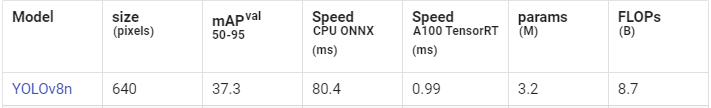

Para él encontramos, que el modelo acepta imágenes de **tamaño** 640x640 píxeles. La métrica **mAPval 50-95**, indica el promedio de la precisión promedio (AP) en un rango de umbrales de IoU del 50% al 95% en el conjunto de datos de validación. La **velocidad con CPU ONNX**, indica la velocidad de inferencia del modelo utilizando la CPU y el formato ONNX (Open Neural Network Exchange) para realizar inferencias (80.4 ms por imagen). La **velocidad con A100 TensorRT**, indica la velocidad de inferencia del modelo utilizando la GPU A100 y el motor de inferencia TensorRT para realizar inferencias (0.99 ms por imagen). Los **parámetros del modelo**, indican la cantidad de parámetros (en millones) en el modelo (3.2 millones de parámetros). Los **FLOPs del modelo**, indican la cantidad de operaciones de punto flotante (en mil millones) realizadas por el modelo para procesar una imagen de entrada (8.7 mil millones de operaciones de punto flotante por imagen).

Para utilizar el modelo, los datos de entrenamiento y validación deben estar en el formato requerido (yolov8 en este caso), se debe definir la arquitectura del modelo YOLO que deseas utilizar, como YOLOv8n, así como el modo en el que se quiere trabajar, entrenamiento (train), validación (val), prueba (predict). Y finalmente, configurar los hiperparámetros del modelo según sea el caso.


In [ ]:
#Detección de una imagen de ultralytics, especificando que el modelo es yolov8n en modo de prueba o predicción y la fuente
!yolo predict model=yolov8n.pt source='https://ultralytics.com/images/zidane.jpg'

100% 6.23M/6.23M [00:00<00:00, 87.5MB/s]
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

100% 165k/165k [00:00<00:00, 7.52MB/s]
image 1/1 /content/zidane.jpg: 384x640 2 persons, 1 tie, 85.3ms
Speed: 15.5ms preprocess, 85.3ms inference, 3045.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
#Función para visualizar mejor los resultados
def mostrar_deteccion(dir_o, dir_pr):
    img1 = mpimg.imread(dir_o) #Leer imagen original
    img2 = mpimg.imread(dir_pr) #Leer imagen deteccion

    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) #Figura y ejes

    #Mostrar imagen original en eje 1
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('Imagen Original')

    #Mostrar imagen detección en eje 2
    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('Imagen Detección')

    plt.show() #Mostrar figura

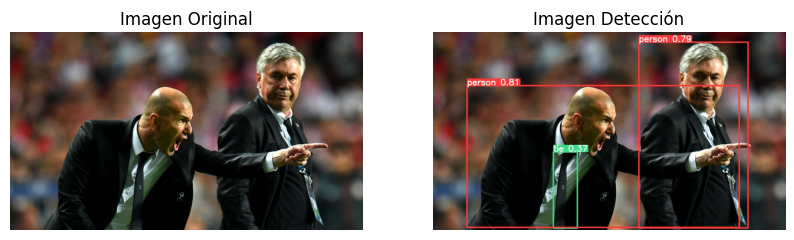

In [ ]:
dir_original = "/content/zidane.jpg"
dir_deteccion = "/content/runs/detect/predict/zidane.jpg"

mostrar_deteccion(dir_original, dir_deteccion)

Vemos como el modelo es capaz de predecir dos clases diferentes (persona y corbata) presentes en el dataset de COCO, aunque este no es capaz de detectar la corbata del sujeto de la derecha.

In [ ]:
#Detección de una imagen de google, especificando que el modelo es yolov8n en modo de prueba o predicción y la fuente
!yolo predict model=yolov8n.pt source='https://www.shutterstock.com/image-illustration/watercolor-set-wild-savannah-animals-260nw-2226581013.jpg'

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

100% 23.5k/23.5k [00:00<00:00, 80.7MB/s]
image 1/1 /content/watercolor-set-wild-savannah-animals-260nw-2226581013.jpg: 352x640 1 sheep, 2 elephants, 1 zebra, 1 giraffe, 113.5ms
Speed: 3.7ms preprocess, 113.5ms inference, 2024.9ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


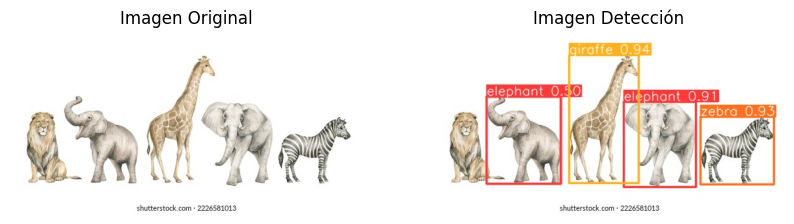

In [ ]:
#Ejemplo 2
dir_original = "/content/watercolor-set-wild-savannah-animals-260nw-2226581013.jpg"
dir_deteccion = "/content/runs/detect/predict2/watercolor-set-wild-savannah-animals-260nw-2226581013.jpg"

mostrar_deteccion(dir_original, dir_deteccion)

Al observar la imagen original vemos 4 clases diferentes (leon, elefante, jirafa, cebra) de 5 animales. Y al realizar la detección este es capaz de detectar 4 animales de 3 clases diferentes (elefante, jirafa, cebra) en donde detecta correctamente ya que el dataset de COCO presenta estas 3 clases y "leon" no es una clase dentro del dataset.

In [ ]:
#Detección de un video de youtube
!yolo predict model=yolov8n.pt source='https://www.youtube.com/watch?v=yIU3S7cgvvM'

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

requirements: Ultralytics requirements ['pafy', 'youtube_dl==2020.12.2'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 7.8s, installed 2 packages: ['pafy', 'youtube_dl==2020.12.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

1/1: https://www.youtube.com/watch?v=yIU3S7cgvvM... Success ✅ (265 frames of shape 320x240 at 24.00 FPS)

0: 480x640 2 persons, 433.7ms
0: 480x640 2 persons, 11.0ms
Speed: 2.9ms preprocess, 222.3ms inference, 984.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


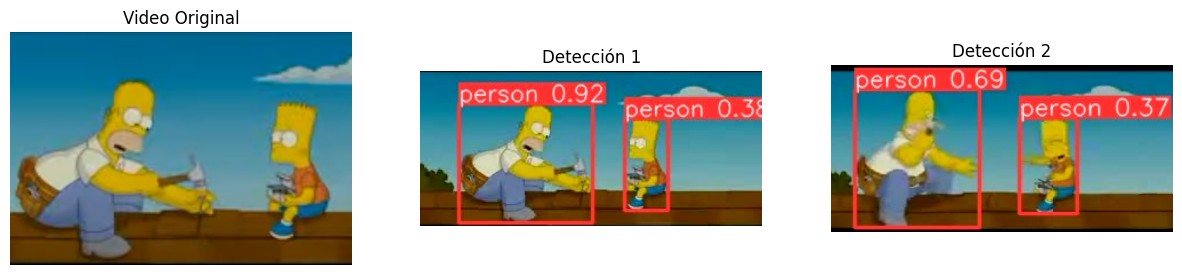

In [ ]:
img0 = mpimg.imread("Video_0.PNG") #Leer original
img1 = mpimg.imread("Video_1.PNG") #Leer deteccion 1
img2 = mpimg.imread("Video_2.PNG") #Leer deteccion 2

fig, axes = plt.subplots(1, 3, figsize=(15, 10)) #Figura y ejes

#Mostrar original en eje 1
axes[0].imshow(img0)
axes[0].axis('off')
axes[0].set_title('Video Original')

#Mostrar detección 1 en eje 2
axes[1].imshow(img1)
axes[1].axis('off')
axes[1].set_title('Detección 1')

#Mostrar detección 2 en eje 3
axes[2].imshow(img2)
axes[2].axis('off')
axes[2].set_title('Detección 2')

plt.show() #Mostrar figura

Al probar el modelo utilizando un video de Youtube de 10 segundo, este detecta dos predicciones, en ambas se detectan dos personas. Como el video con la predicción generada (.avi) tiene una duración inferior al segundo, se optó, por realizar captura de pantalla del mismo, para facilitar su visualización y análisis.

## Entrenar Clase Nueva

Utilizando la plataforma de *Roboflow* se buscó un dataset que tuviera una cantidad considerable de imágenes de una clase que no se encontrara disponible en COCO, al final, la clase escogida fue **pez** en especial el **pez dorado o golden fish** (url del dataset https://universe.roboflow.com/1253971414qqcom-gpnwq/new_fish_detect/dataset/3). En total este consta de 4126 imágenes con una distribución de 3007 para entrenamiento, 938 para validación y 181 de prueba.

In [ ]:
#Buscar el dataset en el drive y extraer los archivos
ruta_drive = '/content/drive/MyDrive/Colab Notebooks/MSc_Data_Science/AML/Deep_learning/new_fish_detect_v3i_yolov8.zip'
ruta_colab = '/content/new_fish_detect_v3i_yolov8.zip'
shutil.copyfile(ruta_drive, ruta_colab)

path = '/content/'
shutil.unpack_archive(ruta_colab, path)

### Entrenamiento

In [ ]:
"""
Entrenamiento con el dataset seleccionado, especificando que el modelo es yolov8n en modo de entrenamiento,
        la ubicación de los datos, 20 épocas y una tasa de aprendizaje inicial de 0.01

En un principio el modelo fue entrenado durante 10 épocas, pero para comparar resultados se amplió a 20 épocas
"""
!yolo train data=data.yaml model=yolov8n.pt epochs=20 lr0=0.01

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

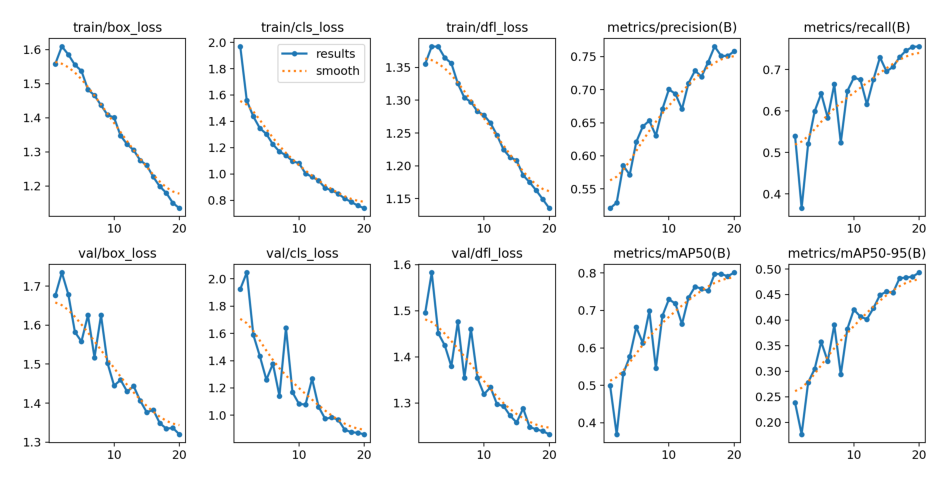

In [ ]:
plt.figure(figsize=(12, 10))
plt.imshow(mpimg.imread("/content/runs/detect/train/results.png"))
plt.axis('off')
plt.show()

* **Pérdida de caja (box_loss)**: Representa la pérdida asociada con la predicción de las coordenadas de las cajas delimitadoras (bounding boxes). Esta métrica mide qué tan precisas son las predicciones del modelo en términos de la ubicación de los objetos detectados en la imagen, entre menor sea el valor este indica que el modelo está prediciendo con precisión las coordenadas de las cajas delimitadoras.
* **Pérdida de clasificación (cls_loss)**: Representa la pérdida asociada con la predicción de las clases de los objetos detectados. Esta métrica mide qué tan preciso es el modelo al clasificar los objetos detectados en diferentes categorías, entre menor sea el valor el modelo está prediciendo con precisión las clases de los objetos detectados.
* **Pérdida focal de distribución (dfl_loss)**: Representa la pérdida asociada con la predicción de las clases de los objetos detectados, teniendo en cuenta el desequilibrio de clases en el conjunto de datos. Esta métrica modula la pérdida basándose en la distribución de clases, dando más peso a las clases minoritarias para mitigar el efecto del desequilibrio de clases en el entrenamiento del modelo. Un valor menor de dfl_loss indica que el modelo está prediciendo con precisión las clases de los objetos detectados, teniendo en cuenta la distribución de clases en el conjunto de datos.

### Validación

In [ ]:
#Validación con el dataset seleccionado, especificando que el modelo es el entrenado anteriormente en modo de validación y la ubicación de los datos
!yolo val model=/content/runs/detect/train/weights/best.pt data=data.yaml

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/valid/labels.cache... 938 images, 10 backgrounds, 0 corrupt: 100% 938/938 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 716, len(boxes) = 2762. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 59/59 [00:29<00:00,  1.98it/s]
                   all        938       2762      0.759      0.758      0.801      0.492
Speed: 0.6ms preprocess, 5.4ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


Métricas:
* **Precisión (P)**: Indica la proporción de detecciones correctas entre todas las detecciones realizadas. Para 10 épocas tuvo un valor de 76%, mientras que, para 20 épocas es de 75.9% es decir que este fue casi el mismo.
* **Recall (R)**: Mide la proporción de detecciones correctas entre todos los objetos reales presentes en las imágenes. Para 10 épocas este fue de 70.9% y para 20 épocas 75.8%. Lo que significa que el modelo fue capaz de reducir los falsos negativos.
* **mAP50 (mean Average Precision)**: Representa el promedio de precisión a lo largo de todas las clases de objetos en el conjunto de validación a un umbral de IoU del 50%. Para 10 épocas fue de 77.6% y para 20 épocas de 80.1%. Indicando que en ambos modelos se logró tener una buena precisión en la detección de objetos para el conjunto de datos.
* **mAP50-95**: Similar al mAP50 pero calculado en un rango más amplio de umbrales de IoU (50% al 95%), para 10 épocas fue del 46.1%, mientras que, para 20 épocas de 49.2% implicando cierta mejora en la precisión de las detecciones para umbrales de IoU más estrictos.
* **Tiempo de entrenamiento**: Al final, para el modelo de 20 épocas el tiempo fue de 42min

La función de validación arroja ciertas salidas visuales

* **Curva de Puntuación F1 (F1_curve.png)**: Representa la puntuación F1 en varios umbrales.
* **Curva de Recall de Precisión (PR_curve.png)**: Muestra las compensaciones entre precisión y recall en umbrales variados.
* **Curva de Precisión (P_curve.png)**: Valores de precisión en diferentes umbrales, ayudando a comprender cómo varía la precisión a medida que cambia el umbral.
* **Curva de Recall (R_curve.png)**: Representa como los valores de recall cambian a través de diferentes umbrales.
* **Matriz de Confusión (confusion_matrix.png)**
* **Matriz de Confusión Normalizada (confusion_matrix_normalized.png)**: Versión normalizada de la matriz de confusión, representa los datos en proporciones en lugar de recuentos brutos, simplificando la comparación del rendimiento entre clases.

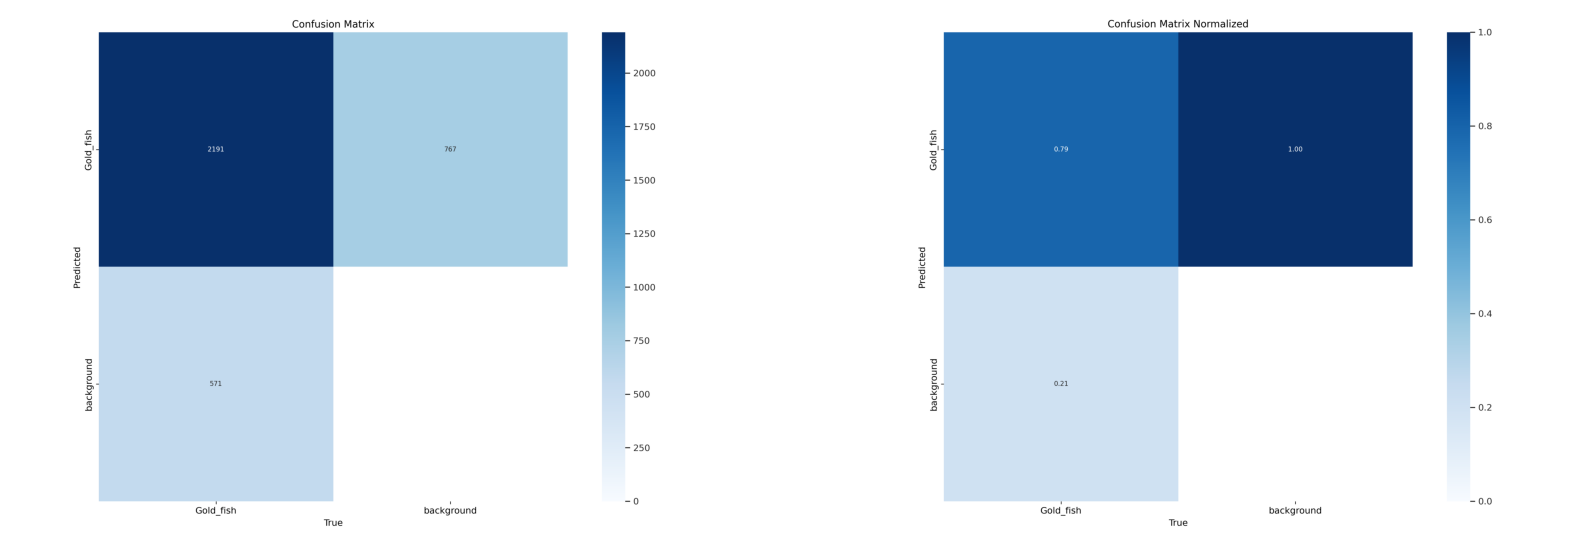

In [ ]:
img1 = mpimg.imread("/content/runs/detect/val/confusion_matrix.png")
img2 = mpimg.imread("/content/runs/detect/val/confusion_matrix_normalized.png")
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) #Figura y ejes
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show() #Mostrar figura

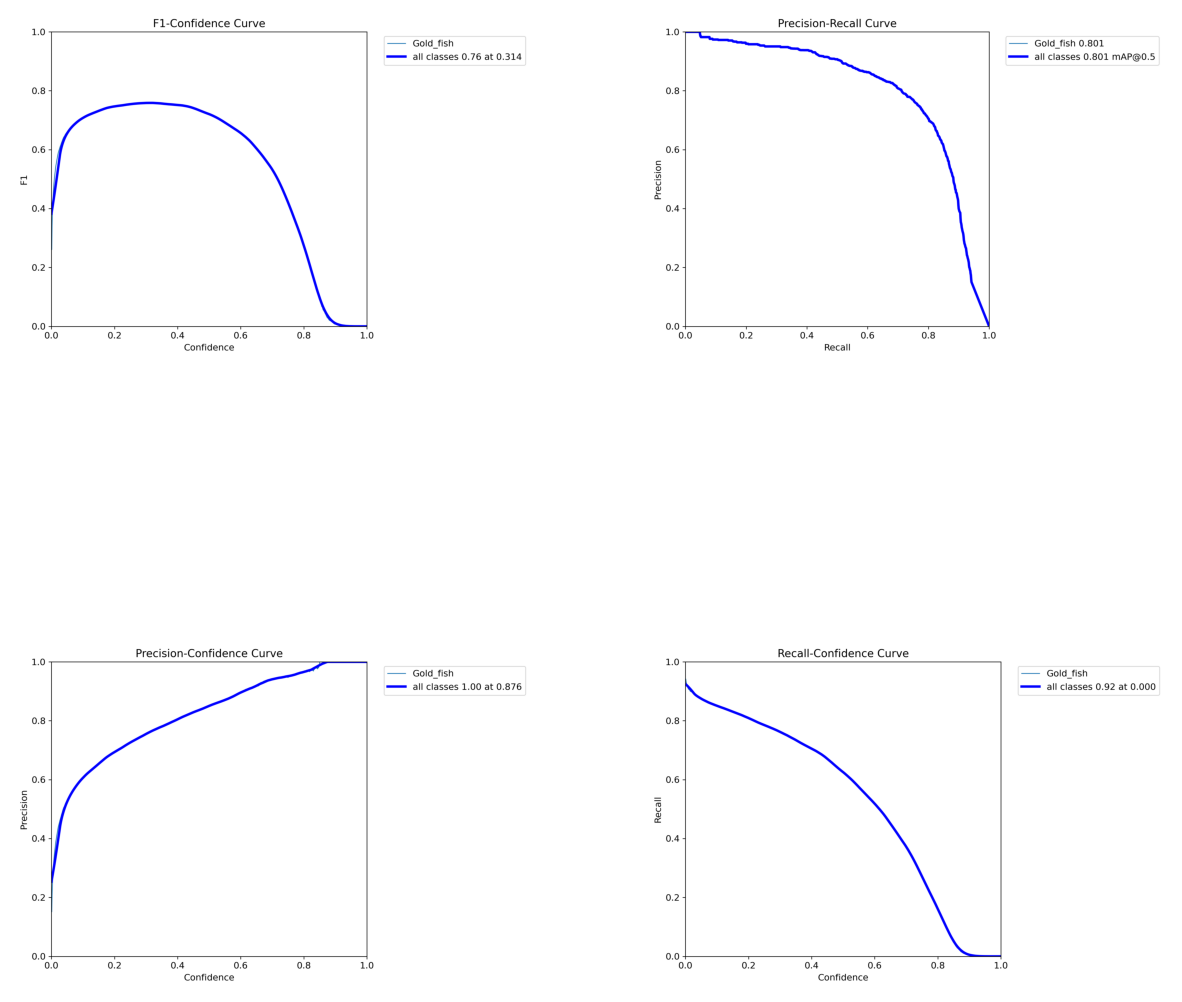

In [ ]:
rutas_metricas = [
    "/content/runs/detect/val/F1_curve.png",
    "/content/runs/detect/val/PR_curve.png",
    "/content/runs/detect/val/P_curve.png",
    "/content/runs/detect/val/R_curve.png" ]
fig, axs = plt.subplots(2, 2, figsize=(15, 15)) #Figura para 4 gráficos
for i, ruta in enumerate(rutas_metricas):
    imagen = mpimg.imread(ruta) #Cargar imagen
    axs[i//2, i%2].imshow(imagen)
    axs[i//2, i%2].axis('off')  #Desactivar ejes
plt.show()

### Pruebas

In [ ]:
#Predicción con el dataset seleccionado, especificando que el modelo es el entrenado anteriormente en modo de validación y la ubicación de los datos
!yolo predict model=/content/runs/detect/train/weights/best.pt source=/content/test/images

Ultralytics YOLOv8.2.1 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/181 /content/test/images/-_2_png.rf.c73bac84b15a3e11562c385296e3dca4.jpg: 352x640 5 Gold_fishs, 91.1ms
image 2/181 /content/test/images/-_4_png.rf.501110b5c7f53781c1d745c50d265d4e.jpg: 352x640 26 Gold_fishs, 13.3ms
image 3/181 /content/test/images/100_jpg.rf.7b35d8ea832451b9914a8a73f54625c9.jpg: 384x640 3 Gold_fishs, 115.5ms
image 4/181 /content/test/images/102_jpg.rf.f7d81e6e0a718bf810996caec829921e.jpg: 384x640 5 Gold_fishs, 9.3ms
image 5/181 /content/test/images/110a327b5e2cb22429e919f0fefb5bd4_jpg.rf.b8b2f86df623bec742ca562b4a928c8b.jpg: 448x640 1 Gold_fish, 116.4ms
image 6/181 /content/test/images/113_jpg.rf.3f37507d6be6cd1556e06f272575a99e.jpg: 384x640 4 Gold_fishs, 10.1ms
image 7/181 /content/test/images/11_jpg.rf.0103335a1eb9b9d98d08f59ae885abca.jpg: 256x640 8 Gold_fishs, 91.3ms
image 8/181 /content/test/im

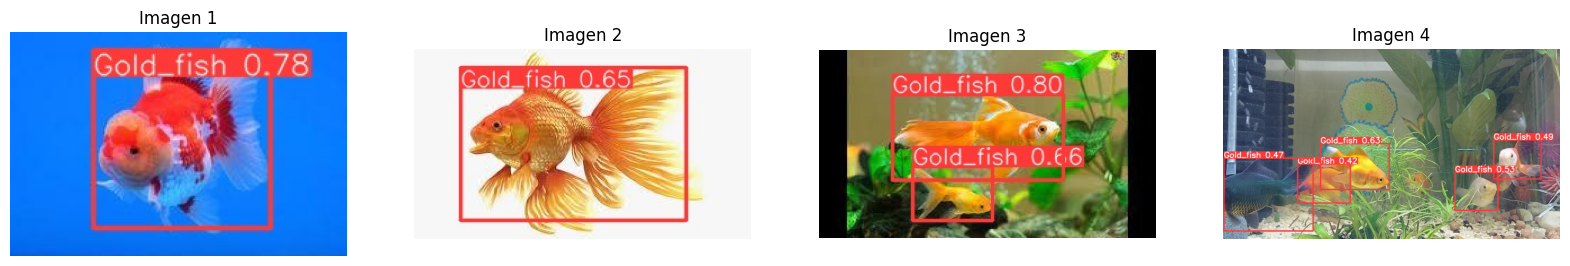

In [ ]:
carp_predicc = "/content/runs/detect/predict4" #Ubicación de las predicciones del dataset de Test
imagenes = os.listdir(carp_predicc) #Lista nombres de imágenes
imagenes_random = random.sample(imagenes, 4) #Seleccionar 4 imágenes a aleatorias

#Mostrar imágenes aleatorias
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, imagen in enumerate(imagenes_random):
    ruta_imagen = os.path.join(carp_predicc, imagen)
    img = mpimg.imread(ruta_imagen)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Imagen {i+1}')
plt.show()

Como el dataset de prueba contiene 181 imágenes se plotearon 4 al azar para visualizar los resultados, donde vemos que el modelo entrenado es capaz de detectar la nueva clase "Gold_fish", en las 4 imágenes mostradas el modelo parece no cometer ningún error.

In [ ]:
#Detección de un imagen de google con la característica de un solo pez, especificando que el modelo es el entrenado anteriormente en modo de predicción/prueba
!yolo predict model=/content/runs/detect/train/weights/best.pt source='https://t3.ftcdn.net/jpg/03/24/84/62/360_F_324846215_AZhKbxzAEQvj9ZKFm0JEr38FWSKJaoVb.jpg'

Ultralytics YOLOv8.2.1 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

100% 34.9k/34.9k [00:00<00:00, 34.9MB/s]
image 1/1 /content/360_F_324846215_AZhKbxzAEQvj9ZKFm0JEr38FWSKJaoVb.jpg: 416x640 1 Gold_fish, 182.0ms
Speed: 4.1ms preprocess, 182.0ms inference, 2102.7ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict5
💡 Learn more at https://docs.ultralytics.com/modes/predict


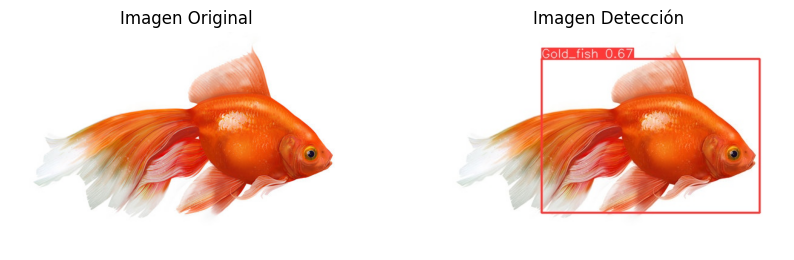

In [ ]:
#Visualización
dir_original = "/content/360_F_324846215_AZhKbxzAEQvj9ZKFm0JEr38FWSKJaoVb.jpg"
dir_deteccion = "/content/runs/detect/predict5/360_F_324846215_AZhKbxzAEQvj9ZKFm0JEr38FWSKJaoVb.jpg"

mostrar_deteccion(dir_original, dir_deteccion)

In [ ]:
#Detección de un imagen de google con la característica de varios peces, especificando que el modelo es el entrenado anteriormente en modo de predicción/prueba
!yolo predict model=/content/runs/detect/train/weights/best.pt source='https://aquariumfishonline.com.au/wp-content/uploads/2020/11/Goldfish-Comet.jpg'

Ultralytics YOLOv8.2.1 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

100% 85.6k/85.6k [00:00<00:00, 263kB/s]
image 1/1 /content/Goldfish-Comet.jpg: 640x640 4 Gold_fishs, 15.4ms
Speed: 6.0ms preprocess, 15.4ms inference, 1929.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict6
💡 Learn more at https://docs.ultralytics.com/modes/predict


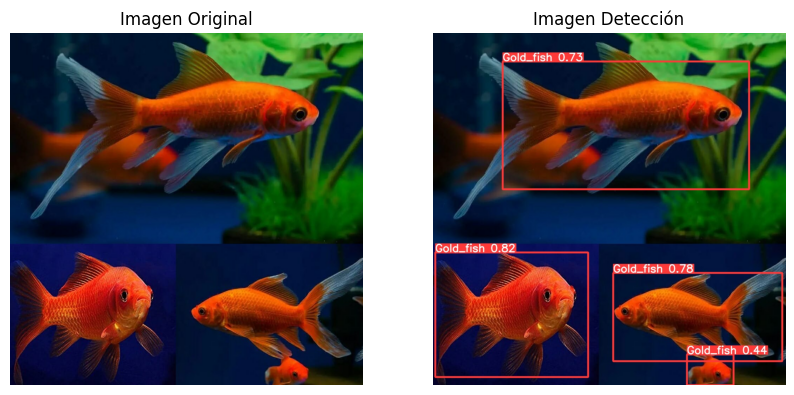

In [ ]:
#Visualización
dir_original = "Goldfish-Comet.jpg"
dir_deteccion = "/content/runs/detect/predict6/Goldfish-Comet.jpg"

mostrar_deteccion(dir_original, dir_deteccion)

Al observar los resultados de las imágenes extraídas de google, vemos que el modelo entrenado sí es capaz de predecir la nueva clase con la que fue entrenado, aunque, en la imagen donde hay varios peces hay uno un poco borroso que el modelo no es capaz de detectar.

In [ ]:
#Detección de un imagen de google sin la clase de peces, ni clases de COCO, especificando que el modelo es el entrenado anteriormente en modo de predicción/prueba
!yolo predict model=/content/runs/detect/train/weights/best.pt source='https://imagenes.heraldo.es/files/image_990_556/uploads/imagenes/2022/08/10/pareja-de-leones-leon-leona.jpeg'

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

Found https://imagenes.heraldo.es/files/image_990_556/uploads/imagenes/2022/08/10/pareja-de-leones-leon-leona.jpeg locally at pareja-de-leones-leon-leona.jpeg
image 1/1 /content/pareja-de-leones-leon-leona.jpeg: 384x640 (no detections), 160.6ms
Speed: 3.4ms preprocess, 160.6ms inference, 1548.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict7
💡 Learn more at https://docs.ultralytics.com/modes/predict


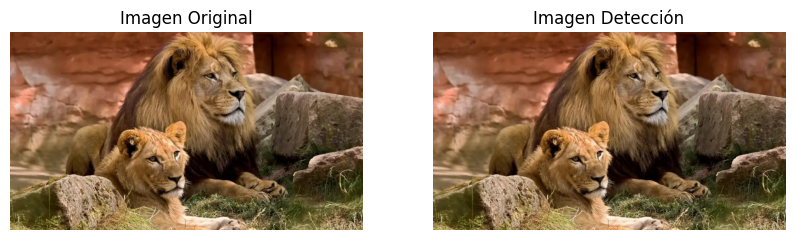

In [ ]:
#Visualización
dir_original = "/content/pareja-de-leones-leon-leona.jpeg"
dir_deteccion = "/content/runs/detect/predict7/pareja-de-leones-leon-leona.jpeg"

mostrar_deteccion(dir_original, dir_deteccion)

Al observar los resultados de la prueba anterior, está nos sirve para evaluar como el modelo es capaz de detectar la ausencia de las clases detectando cero predicciones, lo cual es correcto.

Basandos en los resultados obtenidos a lo largo del proyecto tras evaluar el modelo YOLOv8n en un conjunto de datos de validación, se observa una mejora en su desempeño al aumentar el número de épocas de entrenamiento de 10 a 20. Esta mejora se refleja en métricas claves como la precisión, la recall y el mAP50-95. Específicamente, se observa un aumento modesto pero significativo en el recall y mAP50-95, indicando que el modelo ha aprendido a realizar detecciones más precisas, especialmente en condiciones con mayor desafio. Sin embargo, es importante tener en cuenta el riesgo de sobreajuste al aumentar el número de épocas, ya que un entrenamiento excesivamente prolongado puede conducir a un rendimiento más bajo en datos no vistos.

En conclusión, los resultados obtenidos subrayan la eficacia del modelo YOLOv8n en la tarea de detección de objetos, así como la importancia del proceso de entrenamiento en el rendimiento del modelo, tanto en imágenes de prueba utilizando modelo preentrenados del dataset COCO como realizando predicciones en imágenes de prueba a partir de modelos entrenados con datasets propios. Con un enfoque cuidadoso en el entrenamiento y la evaluación, YOLOv8n muestra ser una opción bastante prometedora para aplicaciones de detección de objetos en diversas industrias y escenarios. Aunque existen otros modelos de la familia de Yolov8  más robustos que pueden dar mejores resultados como el s, m, l, x, a su misma vez el procesamiento, uso de memoria y tiempo de computo también son mayores.